In [22]:
import os
import pcse
import yaml
import h5py
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime as dt
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
from pcse.models import Wofost71_PP, Wofost71_WLP_FD
from pcse.base import ParameterProvider
from pcse.db import NASAPowerWeatherDataProvider
from pcse import fileinput as fi
from pcse.util import WOFOST71SiteDataProvider

In [23]:
agro_yaml = """
Version: 1.0
AgroManagement:
- {sim_start_date}:
    CropCalendar:
        crop_name: maize
        variety_name: Maize_VanHeemst_1988
        crop_start_type: sowing
        crop_start_date: {crop_start_date}
        crop_end_type: earliest
        crop_end_date: {crop_end_date}
        max_duration: 300
    TimedEvents: 
    -   event_signal: apply_n
        name:  Nitrogen application table
        comment: All nitrogen amounts in g N m-2
        events_table:
        - {fert_date}: {{amount: {n_rate}, recovery: 0.7}}
    StateEvents: null
"""

In [24]:
pts = gpd.read_file('../../CIAT/data/BEM_2019_Chiapas_Final_Clean.gpkg')
pts['SIM'] = ['CH{0:05d}'.format(i + 1) for i in range(len(pts))]
pts = pts.set_index('SIM')
pts['lon'] = pts.centroid.x
pts['lat'] = pts.centroid.y
pts['ref_date'] = pd.to_datetime(pts.fecha_de_siembra)
pts['nrate'] = pts.nitrogen/10


In [25]:
soildata = {'SMFCF': 0.2, 'SMW': 0.1, 'CRAIRC': 0.1, 'KSUB': 20.0,
            'RDMSOL': 200.0, 'K0': 100.0, 'SOPE': 10.0, 'SM0': 0.4}

cropdata = fi.YAMLCropDataProvider()
cropdata.set_active_crop('maize', 'Maize_VanHeemst_1988')

sitedata = WOFOST71SiteDataProvider(WAV=100, CO2=360)

parameters = ParameterProvider(cropdata=cropdata, soildata=soildata, sitedata=sitedata)

In [26]:
# for i in trange(len(pts)):
#     if np.isnan(pts.index_right.values[i]):
#         continue

#     wfile = '/home/rodrigo7/Apsim_test/MASAGRO/PCSE/{}_npff.csv'.format(pts.site.values[i])
#     wdp = fi.CSVWeatherDataProvider(wfile)

#     # get new start date
#     crop_start_date = pts.ref_date.dt.date.values[i]
#     sim_start_date = crop_start_date - dt.timedelta(days = 90)
#     crop_end_date = crop_start_date + dt.timedelta(days = 210)
#     fert_date = crop_start_date + dt.timedelta(days = 30)
#     n_rate = 1

#     # update agromanagement with new start date and load it with yaml.load
#     tmp = agro_yaml.format(sim_start_date = sim_start_date,
#                            crop_start_date = crop_start_date,
#                            crop_end_date = crop_end_date,
#                            fert_date = fert_date,
#                            n_rate = n_rate)
#     agromanagement = yaml.load(tmp, yaml.FullLoader)

#     try:
#         wofsim = Wofost71_WLP_FD(parameters, wdp, agromanagement)
#         wofsim.run_till_terminate()
#         print('Finished {}'.format(pts.site.values[i]))
#         output = wofsim.get_output()
#         df = pd.DataFrame(output).set_index("day")
#         df.to_hdf('../data/PSCE_npf.h5', key = pts.site.values[i])
#         summary_output = wofsim.get_summary_output()
#         msg = "Reached maturity at {DOM} with total biomass {TAGP:0.2f} kg/ha and a yield of {TWSO:0.2f} kg/ha."
#         print(msg.format(**summary_output[0]))
#     except pcse.exceptions.WeatherDataProviderError as e:
#         print('Problem with {}'.format(pts.site.values[i]))
#         print(e)
#         print(crop_start_date)



In [55]:
def run(site):
        wfile = f'/home/rodrigo7/Apsim_test/MASAGRO/PCSE/{site}_npff.csv'
        wdp = fi.CSVWeatherDataProvider(wfile)

        # get new start date
        crop_start_date = pts.ref_date.dt.date.loc[site]
        sim_start_date = crop_start_date - dt.timedelta(days = 90)
        crop_end_date = crop_start_date + dt.timedelta(days = 210)
        fert_date = crop_start_date + dt.timedelta(days = 30)
        n_rate = 1

        # update agromanagement with new start date and load it with yaml.load
        tmp = agro_yaml.format(sim_start_date = sim_start_date,
                               crop_start_date = crop_start_date,
                               crop_end_date = crop_end_date,
                               fert_date = fert_date,
                               n_rate = n_rate)
        agromanagement = yaml.load(tmp, yaml.FullLoader)

        wofsim = Wofost71_WLP_FD(parameters, wdp, agromanagement)
        wofsim.run_till_terminate()
        output = wofsim.get_output()
        df = pd.DataFrame(output).set_index("day")
        df['SIM'] = site
        return(df)


In [59]:
site = sites[85]
# run(site)

# wfile = f'/home/rodrigo7/Apsim_test/MASAGRO/PCSE/{site}_npff.csv'
# w = pd.read_csv(wfile, skiprows=13)
# w

In [72]:
# sites = pts.index.values
# output = []
# with tqdm(total=len(sites)) as pbar:
#     for i, s in enumerate(sites):
#         output.append(run(s))
#         pbar.update()

In [60]:
from multiprocessing import Pool

sites = pts.index.values
output = []
if __name__ == '__main__':
    with Pool(processes=30) as p:
        with tqdm(total=len(pts)) as pbar:
            for i, df in enumerate(p.imap_unordered(run, sites)):
                output.append(df)
                pbar.update()


In [69]:
output_df = pd.DataFrame([o.iloc[-1] for o in output])

In [73]:
df.to_hdf('../data/PSCE_npff.h5', key = 'SIM')

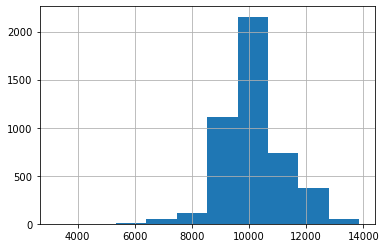

In [71]:
output_df.TWSO.hist()

In [61]:
# for k, v in output.items():
#     if v is not None:
#         print(k)
#         df = pd.DataFrame(v).set_index("day")
#         df.to_hdf('../data/PSCE_npff.h5', key = k)